In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
rng = np.random.default_rng()

# Shot Analysis & Pose Type Selection

In [3]:
def classify_shot(shot_x, shot_y, torso_x=13.5):
    """
    Determine the type of save required based on shot position.
    Returns: pose_type and urgency
    """
    # Calculate shot characteristics
    horizontal_distance = abs(shot_x - torso_x)
    height_category = 'low' if shot_y < 9 else 'mid' if shot_y < 18 else 'high'
    side = 'left' if shot_x < torso_x else 'right' if shot_x > torso_x else 'center'
    
    # Determine pose type
    if horizontal_distance < 3:
        if height_category == 'high':
            return 'reaching_up', 0.6
        elif height_category == 'low':
            return 'crouching', 0.4
        else:
            return 'standing_block', 0.3
    elif horizontal_distance < 8:
        if height_category == 'low':
            return 'lateral_dive_low', 0.8
        else:
            return 'lateral_dive_high', 0.9
    else:  # Far shot
        return 'full_extension_dive', 1.0

# Torso Positioning

In [4]:
def generate_torso_position(shot_x, shot_y, pose_type, base_x=13.5, base_y=15):
    """
    Generate torso position based on shot and pose type.
    base_y=10 represents standing torso height (~1.6-1.8m above ground)
    """
    torso = {}
    
    # Horizontal movement toward shot
    if 'dive' in pose_type:
        # Torso moves significantly toward shot
        movement_factor = 0.4 if 'full_extension' in pose_type else 0.25
        torso['x'] = base_x + (shot_x - base_x) * movement_factor
        
        # Torso drops during dive
        if 'low' in pose_type:
            torso['y'] = base_y * 0.4  # Near ground
        else:
            torso['y'] = base_y * 0.6  # Mid-height
            
    elif pose_type == 'reaching_up':
        torso['x'] = base_x + rng.normal(0, 0.5)  # Minimal lateral movement
        torso['y'] = base_y * 1.1  # Slight upward push
        
    elif pose_type == 'crouching':
        torso['x'] = base_x + rng.normal(0, 0.5)
        torso['y'] = base_y * 0.6  # Lower position
        
    else:  # standing_block
        torso['x'] = base_x + rng.normal(0, 1)
        torso['y'] = base_y
    
    # Add realistic variation
    torso['x'] += rng.normal(0, 0.3)
    torso['y'] += rng.normal(0, 0.2)
    
    return torso

In [5]:
def generate_head_position(torso, pose_type):
    """Head is ~0.25m above torso center"""
    head = {
        'x': torso['x'] + rng.normal(0, 0.2),  # Slight lateral variation
        'y': torso['y'] + 2.5  # Fixed offset upward
    }
    
    # In diving poses, head may tilt toward ball
    if 'dive' in pose_type:
        head['y'] += rng.uniform(-0.3, 0.1)
    
    return head

In [6]:
# Anatomical constants (in coordinate units, where 27 units ≈ 2.4m goal height)
LIMB_LENGTHS = {
    'upper_arm': 3.0,    # shoulder to elbow
    'forearm': 2.5,      # elbow to hand
    'thigh': 4.0,        # hip to knee
    'shin': 4.0          # knee to foot
}

JOINT_LIMITS = {
    'shoulder': (-180, 180),  # Full rotation
    'elbow': (0, 160),        # Can't hyperextend backward
    'hip': (-90, 135),        # Limited backward, good forward
    'knee': (0, 150)          # Can't bend backward
}

def place_arm_toward_target(shoulder_pos, target_x, target_y, side='right'):
    """
    Use inverse kinematics to place arm reaching toward target.
    Returns: elbow and hand positions
    """
    # Calculate desired hand position (toward shot, but within reach)
    max_reach = LIMB_LENGTHS['upper_arm'] + LIMB_LENGTHS['forearm']
    
    # Vector from shoulder to target
    dx = target_x - shoulder_pos['x']
    dy = target_y - shoulder_pos['y']
    distance = np.sqrt(dx**2 + dy**2)
    
    # If target is beyond reach, extend fully in that direction
    if distance > max_reach:
        reach_factor = max_reach * 0.95  # Slight bend even at full extension
        hand_x = shoulder_pos['x'] + (dx / distance) * reach_factor
        hand_y = shoulder_pos['y'] + (dy / distance) * reach_factor
    else:
        # Target is reachable with bent arm
        reach_factor = distance * rng.uniform(0.85, 0.98)
        hand_x = shoulder_pos['x'] + (dx / distance) * reach_factor
        hand_y = shoulder_pos['y'] + (dy / distance) * reach_factor
    
    # Calculate elbow position using two-joint IK
    elbow = calculate_elbow_position(
        shoulder_pos, 
        {'x': hand_x, 'y': hand_y},
        LIMB_LENGTHS['upper_arm'],
        LIMB_LENGTHS['forearm'],
        side
    )
    
    return elbow, {'x': hand_x, 'y': hand_y}

def calculate_elbow_position(shoulder, hand, upper_len, forearm_len, side):
    """
    Two-joint inverse kinematics solver for elbow position.
    Uses the law of cosines to find valid elbow position.
    """
    # Distance from shoulder to hand
    dx = hand['x'] - shoulder['x']
    dy = hand['y'] - shoulder['y']
    distance = np.sqrt(dx**2 + dy**2)
    
    # Ensure reachable (should already be checked, but safety)
    distance = min(distance, upper_len + forearm_len - 0.1)
    
    # Angle at elbow using law of cosines
    cos_elbow = (upper_len**2 + forearm_len**2 - distance**2) / (2 * upper_len * forearm_len)
    cos_elbow = np.clip(cos_elbow, -1, 1)
    elbow_angle = np.arccos(cos_elbow)
    
    # Angle of line from shoulder to hand
    baseline_angle = np.arctan2(dy, dx)
    
    # Angle to elbow from shoulder
    cos_shoulder = (upper_len**2 + distance**2 - forearm_len**2) / (2 * upper_len * distance)
    cos_shoulder = np.clip(cos_shoulder, -1, 1)
    shoulder_angle = np.arccos(cos_shoulder)
    
    # Elbow can be above or below the line - choose based on side and natural motion
    if side == 'right':
        elbow_direction = baseline_angle + shoulder_angle
    else:
        elbow_direction = baseline_angle - shoulder_angle
    
    elbow = {
        'x': shoulder['x'] + upper_len * np.cos(elbow_direction),
        'y': shoulder['y'] + upper_len * np.sin(elbow_direction)
    }
    
    return elbow

In [7]:
def place_balance_arm(shoulder_pos, torso, pose_type, side='right'):
    """
    Generate position for the non-primary arm (provides balance/secondary protection).
    This arm typically stays closer to the body or extends partially.
    """
    if 'dive' in pose_type:
        # During a dive, balance arm extends outward but not toward shot
        # It helps with balance and covers more area
        if side == 'right':
            target_x = shoulder_pos['x'] + 3.0
        else:
            target_x = shoulder_pos['x'] - 3.0
        
        target_y = shoulder_pos['y'] + rng.uniform(-1, 2)
        
    elif pose_type == 'reaching_up':
        # Both arms tend to go up, balance arm slightly lower
        target_x = shoulder_pos['x'] + rng.uniform(-1, 1)
        target_y = shoulder_pos['y'] + 4.0
        
    elif pose_type == 'crouching':
        # Arms out to sides or slightly forward
        if side == 'right':
            target_x = shoulder_pos['x'] + 2.5
        else:
            target_x = shoulder_pos['x'] - 2.5
        target_y = shoulder_pos['y'] - 1.0
        
    else:  # standing_block
        # Arm stays closer to body in ready position
        if side == 'right':
            target_x = shoulder_pos['x'] + 2.0
        else:
            target_x = shoulder_pos['x'] - 2.0
        target_y = shoulder_pos['y'] + rng.uniform(0, 1.5)
    
    # Use same IK solver as primary arm
    elbow, hand = place_arm_toward_target(shoulder_pos, target_x, target_y, side)
    
    return elbow, hand


def generate_diving_legs(l_hip, r_hip, torso, shot_x, pose_type):
    """
    Generate leg positions for diving poses.
    Typically: one leg pushes off (extended), other leg tucks or trails.
    """
    # Determine which direction the dive is going
    diving_left = shot_x < torso['x']
    
    if diving_left:
        # Pushing off with right leg, left leg leads/tucks
        # Right leg (pushing leg) - more extended
        r_knee = {
            'x': r_hip['x'] + rng.uniform(0.5, 1.5),
            'y': r_hip['y'] - LIMB_LENGTHS['thigh'] * 0.7
        }
        r_foot = {
            'x': r_knee['x'] + rng.uniform(0.5, 1.5),
            'y': max(0.5, r_knee['y'] - LIMB_LENGTHS['shin'] * 0.8)
        }
        
        # Left leg (leading leg) - more tucked
        l_knee = {
            'x': l_hip['x'] - rng.uniform(1.0, 2.0),
            'y': l_hip['y'] - LIMB_LENGTHS['thigh'] * 0.5
        }
        l_foot = {
            'x': l_knee['x'] - rng.uniform(0.5, 1.5),
            'y': max(0.5, l_knee['y'] - LIMB_LENGTHS['shin'] * 0.6)
        }
    else:
        # Pushing off with left leg, right leg leads/tucks
        # Left leg (pushing leg) - more extended
        l_knee = {
            'x': l_hip['x'] - rng.uniform(0.5, 1.5),
            'y': l_hip['y'] - LIMB_LENGTHS['thigh'] * 0.7
        }
        l_foot = {
            'x': l_knee['x'] - rng.uniform(0.5, 1.5),
            'y': max(0.5, l_knee['y'] - LIMB_LENGTHS['shin'] * 0.8)
        }
        
        # Right leg (leading leg) - more tucked
        r_knee = {
            'x': r_hip['x'] + rng.uniform(1.0, 2.0),
            'y': r_hip['y'] - LIMB_LENGTHS['thigh'] * 0.5
        }
        r_foot = {
            'x': r_knee['x'] + rng.uniform(0.5, 1.5),
            'y': max(0.5, r_knee['y'] - LIMB_LENGTHS['shin'] * 0.6)
        }
    
    # Ensure feet don't go below ground
    l_foot['y'] = max(0.5, l_foot['y'])
    r_foot['y'] = max(0.5, r_foot['y'])
    
    return l_knee, l_foot, r_knee, r_foot


def generate_crouching_legs(l_hip, r_hip):
    """
    Generate leg positions for crouching/ready stance.
    Both legs bent, feet planted on ground.
    """
    # Left leg - bent knee, foot on ground
    l_knee = {
        'x': l_hip['x'] - rng.uniform(0.3, 0.8),
        'y': l_hip['y'] - LIMB_LENGTHS['thigh'] * 0.8
    }
    l_foot = {
        'x': l_knee['x'] - rng.uniform(0.2, 0.6),
        'y': 0.5  # On ground
    }
    
    # Right leg - bent knee, foot on ground
    r_knee = {
        'x': r_hip['x'] + rng.uniform(0.3, 0.8),
        'y': r_hip['y'] - LIMB_LENGTHS['thigh'] * 0.8
    }
    r_foot = {
        'x': r_knee['x'] + rng.uniform(0.2, 0.6),
        'y': 0.5  # On ground
    }
    
    return l_knee, l_foot, r_knee, r_foot


def generate_standing_legs(l_hip, r_hip, torso):
    """
    Generate leg positions for standing/reaching poses.
    Legs relatively straight, may be slightly bent.
    """
    # Left leg - mostly straight
    l_knee = {
        'x': l_hip['x'] - rng.uniform(0.1, 0.4),
        'y': l_hip['y'] - LIMB_LENGTHS['thigh'] * 0.9
    }
    l_foot = {
        'x': l_knee['x'] - rng.uniform(0.1, 0.3),
        'y': 0.5  # On ground
    }
    
    # Right leg - mostly straight
    r_knee = {
        'x': r_hip['x'] + rng.uniform(0.1, 0.4),
        'y': r_hip['y'] - LIMB_LENGTHS['thigh'] * 0.9
    }
    r_foot = {
        'x': r_knee['x'] + rng.uniform(0.1, 0.3),
        'y': 0.5  # On ground
    }
    
    # For reaching up poses, keeper may be on tiptoes or jumping slightly
    if torso['y'] > 11:  # Torso higher than normal standing
        l_foot['y'] = rng.uniform(0.5, 2.0)
        r_foot['y'] = rng.uniform(0.5, 2.0)
    
    return l_knee, l_foot, r_knee, r_foot

In [8]:
def generate_complete_pose(shot_x, shot_y):
    """
    Generate all 14 nodes for goalkeeper pose.
    """
    # Step 1: Analyze shot
    pose_type, urgency = classify_shot(shot_x, shot_y)
    
    # Step 2: Position torso (anchor point)
    torso = generate_torso_position(shot_x, shot_y, pose_type)
    
    # Step 3: Place head
    head = generate_head_position(torso, pose_type)
    
    # Step 4: Position shoulders (fixed offset from torso)
    shoulder_width = 2.0
    l_shoulder = {'x': torso['x'] - shoulder_width, 'y': torso['y'] + 1.5}
    r_shoulder = {'x': torso['x'] + shoulder_width, 'y': torso['y'] + 1.5}
    
    # Step 5: Position hips (fixed offset from torso)
    hip_width = 1.5
    hip_drop = 2.0  # Hips below torso center
    l_hip = {'x': torso['x'] - hip_width, 'y': torso['y'] - hip_drop}
    r_hip = {'x': torso['x'] + hip_width, 'y': torso['y'] - hip_drop}
    
    # Step 6: Generate arms based on shot position
    # Determine which arm is primary (closer to shot)
    if shot_x < torso['x']:  # Shot on left
        # Left arm reaches toward shot
        l_elbow, l_hand = place_arm_toward_target(l_shoulder, shot_x, shot_y, 'left')
        # Right arm provides balance
        r_elbow, r_hand = place_balance_arm(r_shoulder, torso, pose_type, 'right')
    else:  # Shot on right or center
        r_elbow, r_hand = place_arm_toward_target(r_shoulder, shot_x, shot_y, 'right')
        l_elbow, l_hand = place_balance_arm(l_shoulder, torso, pose_type, 'left')
    
    # Step 7: Generate legs based on pose type
    if 'dive' in pose_type:
        l_knee, l_foot, r_knee, r_foot = generate_diving_legs(
            l_hip, r_hip, torso, shot_x, pose_type
        )
    elif pose_type == 'crouching':
        l_knee, l_foot, r_knee, r_foot = generate_crouching_legs(l_hip, r_hip)
    else:  # Standing or reaching
        l_knee, l_foot, r_knee, r_foot = generate_standing_legs(l_hip, r_hip, torso)
    
    # Return all 14 nodes
    return {
        'torso': torso,
        'head': head,
        'l_shoulder': l_shoulder,
        'r_shoulder': r_shoulder,
        'l_elbow': l_elbow,
        'r_elbow': r_elbow,
        'l_hand': l_hand,
        'r_hand': r_hand,
        'l_hip': l_hip,
        'r_hip': r_hip,
        'l_knee': l_knee,
        'r_knee': r_knee,
        'l_foot': l_foot,
        'r_foot': r_foot
    }

In [9]:
generate_complete_pose(10, 15)

{'torso': {'x': 12.635794906459765, 'y': 9.035054594486404},
 'head': {'x': 12.824910415908557, 'y': 11.56052067970399},
 'l_shoulder': {'x': 10.635794906459765, 'y': 10.535054594486404},
 'r_shoulder': {'x': 14.635794906459765, 'y': 10.535054594486404},
 'l_elbow': {'x': np.float64(12.080059614987428),
  'y': np.float64(13.164522116952027)},
 'r_elbow': {'x': np.float64(15.126322695498427),
  'y': np.float64(13.494679991083217)},
 'l_hand': {'x': np.float64(10.053006353490952),
  'y': np.float64(14.627756573577656)},
 'r_hand': {'x': np.float64(17.19871430726345),
  'y': np.float64(12.09639782803959)},
 'l_hip': {'x': 11.135794906459765, 'y': 7.035054594486404},
 'r_hip': {'x': 14.135794906459765, 'y': 7.035054594486404},
 'l_knee': {'x': 9.893955692902775, 'y': 5.035054594486404},
 'r_knee': {'x': 15.330205793044703, 'y': 4.235054594486404},
 'l_foot': {'x': 9.34023761186642, 'y': 2.635054594486404},
 'r_foot': {'x': 16.525360059864436, 'y': 1.0350545944864038}}

In [10]:
# Convert pose to DataFrame for better visualization
pose = generate_complete_pose(10, 15)
pose_df = pd.DataFrame(pose).T  # Transpose to have nodes as rows
pose_df.columns = ['x', 'y']
pose_df.index.name = 'node'
pose_df

,x,y
node,,
torso,12.277940,9.248272
head,12.054654,11.671029
l_shoulder,10.277940,10.748272
r_shoulder,14.277940,10.748272
l_elbow,12.046742,13.171356
r_elbow,16.354184,12.913731
l_hand,10.023539,14.639910
r_hand,16.882760,10.470248
l_hip,10.777940,7.248272


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


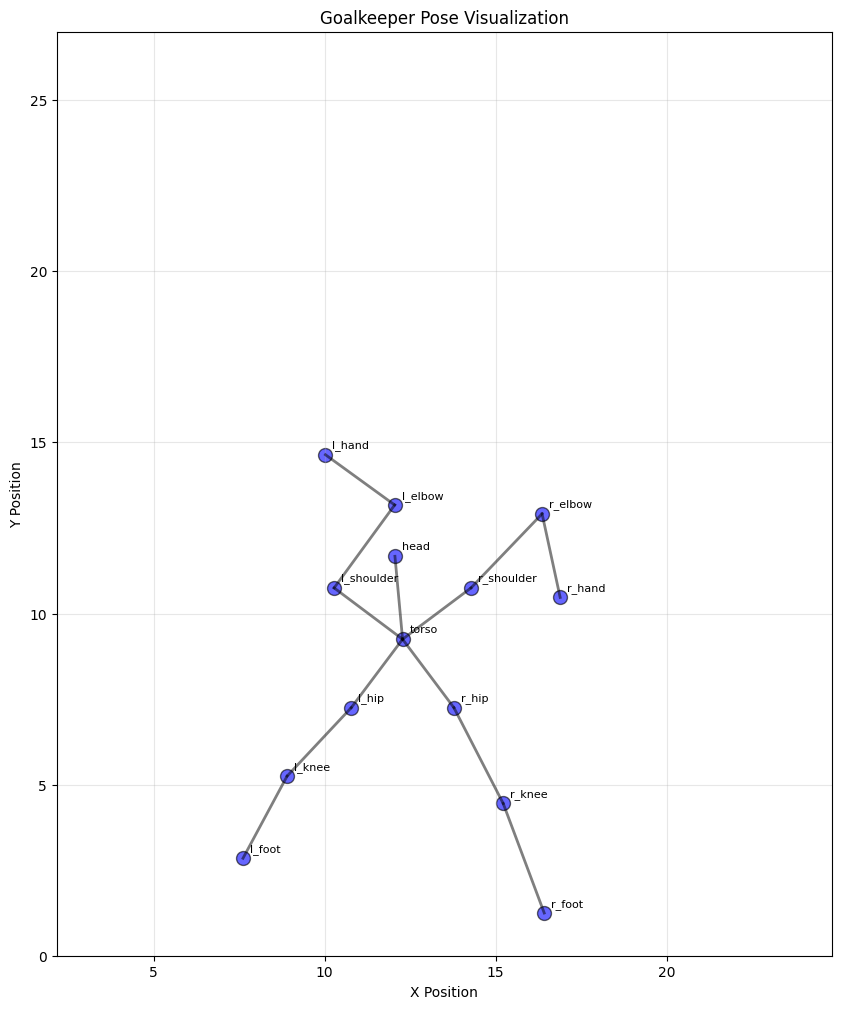

In [11]:
# Create scatter plot of the pose
plt.figure(figsize=(10, 12))
plt.scatter(pose_df['x'], pose_df['y'], s=100, c='blue', alpha=0.6, edgecolors='black')

# Label each node
for node, (x, y) in pose_df.iterrows():
    plt.annotate(node, (x, y), xytext=(5, 5), textcoords='offset points', fontsize=8)

# Draw skeleton connections
connections = [
    ('torso', 'head'),
    ('torso', 'l_shoulder'), ('torso', 'r_shoulder'),
    ('l_shoulder', 'l_elbow'), ('l_elbow', 'l_hand'),
    ('r_shoulder', 'r_elbow'), ('r_elbow', 'r_hand'),
    ('torso', 'l_hip'), ('torso', 'r_hip'),
    ('l_hip', 'l_knee'), ('l_knee', 'l_foot'),
    ('r_hip', 'r_knee'), ('r_knee', 'r_foot')
]

for node1, node2 in connections:
    x_vals = [pose_df.loc[node1, 'x'], pose_df.loc[node2, 'x']]
    y_vals = [pose_df.loc[node1, 'y'], pose_df.loc[node2, 'y']]
    plt.plot(x_vals, y_vals, 'k-', alpha=0.5, linewidth=2)

plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Goalkeeper Pose Visualization')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.xlim(0, 27)
plt.ylim(0, 27)
plt.show()